# **Heart Disease Health Indicators Data Modeling - K Neighbors Classifier**

We aim to develop a predictive model that can accurately identify individuals who are at a higher risk of developing heart disease. We will use various machine learning algorithms to train our models and evaluate their performance using different metrics. The ultimate goal is to create a model that can be used by healthcare providers to identify high-risk patients and intervene early to prevent heart disease.

In [1]:
# General Libraries
import time
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Load and read the data
heart_data = pd.read_csv('../data/2021_brfss_ohe_heart_disease_health_indicators.csv')
heart_data.head()

,target,HighBP,HighChol,CholCheck,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,income_grp_10k-15k USD,income_grp_150k-200k USD,income_grp_15k-20k USD,income_grp_200k USD or more,income_grp_20k-25k USD,income_grp_25k-35k USD,income_grp_35k-50k USD,income_grp_50k-75k USD,income_grp_75k-100k USD,income_grp_Less than 10k USD
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


## Proportion Chance Criterion

Would Recommend:          0
0.0  200163
1.0   20248
Proportion Chance Criterion: 83.31%
1.25 * Proportion Chance Criterion: 104.14%


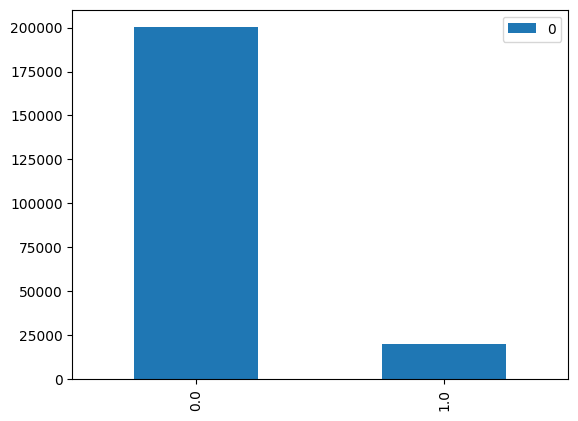

In [3]:
state_counts = Counter(heart_data['target'])
heart_data_state = pd.DataFrame.from_dict(state_counts, orient='index')
heart_data_state.plot(kind='bar')

num=(heart_data_state[0]/heart_data_state[0].sum())**2

print("Would Recommend:{}".format(heart_data_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

## Data Splitting

In [4]:
# Separate the feature and target variables
X = heart_data.drop(['target'], axis=1)
y = heart_data['target']

In [5]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                            random_state=42, 
                                                            test_size=0.20,
                                                            stratify=y)

In [6]:
# Check the train-val data
X_trainval.head()

,HighBP,HighChol,CholCheck,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthInsurance,...,income_grp_10k-15k USD,income_grp_150k-200k USD,income_grp_15k-20k USD,income_grp_200k USD or more,income_grp_20k-25k USD,income_grp_25k-35k USD,income_grp_35k-50k USD,income_grp_50k-75k USD,income_grp_75k-100k USD,income_grp_Less than 10k USD
22913,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
206459,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,0
3667,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0
86209,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
29322,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,0


## Build and Train the Model with Auto ML

In [7]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {} # for plots/viz results
    results2 = {} # table results

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        # accuracy scores
        train_scores = []
        val_scores = []

        # recall scores
        train_recall = []
        val_recall = []
        
        # precision scores
        train_prec = []
        val_prec = []
        
        #f1 scores
        train_f1 = []
        val_f1 = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling to standardize values
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else: # else use raw data
                pass 

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            # precision
            train_prec.append(precision_score(y_train, train_preds))
            val_prec.append(precision_score(y_val, val_preds))
            
            # f1
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))
            
            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train Precision': np.round(np.mean(train_prec) * 100, 2),
                'Val Precision': np.round(np.mean(val_prec) * 100, 2),
                'Train F1 Score': np.round(np.mean(train_f1) * 100, 2),
                'Val F1 Score': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_prec)*100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_prec)*100, 2)),
                'Train F1 Score': '{:.2f}%'.format(np.round(np.mean(train_f1)*100, 2)),
                'Val F1 Score': '{:.2f}%'.format(np.round(np.mean(val_f1)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

### Baseline Model

In [8]:
models_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(), 
    'RandomForestClassifier': RandomForestClassifier(random_state=143),
}

In [9]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, cv=StratifiedKFold(n_splits=5))

auto = auto_run[0]
auto_run[1] # table results

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Train Precision,Val Precision,Train F1 Score,Val F1 Score,Run Time
KNeighborsClassifier,91.83%,89.85%,20.80%,9.12%,68.03%,31.76%,31.85%,14.17%,55.790107
RandomForestClassifier,99.28%,90.38%,93.24%,8.17%,98.88%,38.71%,95.98%,13.49%,54.721297


In [10]:
auto_run

[                        Train Accuracy  Val Accuracy  Train Recall  \
 KNeighborsClassifier             91.83         89.85         20.80   
 RandomForestClassifier           99.28         90.38         93.24   
 
                         Val Recall  Train Precision  Val Precision  \
 KNeighborsClassifier          9.12            68.03          31.76   
 RandomForestClassifier        8.17            98.88          38.71   
 
                         Train F1 Score  Val F1 Score   Run Time  
 KNeighborsClassifier             31.85         14.17  55.790107  
 RandomForestClassifier           95.98         13.49  54.721297  ,
                        Train Accuracy Val Accuracy Train Recall Val Recall  \
 KNeighborsClassifier           91.83%       89.85%       20.80%      9.12%   
 RandomForestClassifier         99.28%       90.38%       93.24%      8.17%   
 
                        Train Precision Val Precision Train F1 Score  \
 KNeighborsClassifier            68.03%        31.76%    

## Applying Resampling Techniques

### Undersampling

In [11]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict,
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------TomekLinks-------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 18.903870820999146
Resampling done in 18.677147150039673
Resampling done in 18.773319721221924
Resampling done in 17.482273817062378
Resampling done in 16.330031633377075


0it [00:00, ?it/s]

Resampling done in 17.33242154121399
Resampling done in 17.95270872116089
Resampling done in 16.635807037353516
Resampling done in 17.839919805526733
Resampling done in 16.675984382629395


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Train Precision,Val Precision,Train F1 Score,Val F1 Score,Run Time
KNeighborsClassifier,92.08%,89.63%,24.94%,11.35%,72.63%,31.89%,37.13%,16.74%,48.39036
RandomForestClassifier,99.27%,90.33%,93.33%,10.46%,98.81%,39.87%,95.99%,16.57%,47.328657


-------------------------------------------------NearMiss--------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 2.1610238552093506
Resampling done in 1.946683645248413
Resampling done in 1.7589962482452393
Resampling done in 1.9560959339141846
Resampling done in 1.8707287311553955


0it [00:00, ?it/s]

Resampling done in 1.982405185699463
Resampling done in 2.2033259868621826
Resampling done in 2.0206682682037354
Resampling done in 2.0485968589782715
Resampling done in 1.9868805408477783


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Train Precision,Val Precision,Train F1 Score,Val F1 Score,Run Time
KNeighborsClassifier,82.10%,52.49%,66.06%,62.50%,97.26%,11.53%,78.68%,19.46%,5.818927
RandomForestClassifier,96.12%,36.53%,93.74%,79.97%,98.44%,10.65%,96.03%,18.80%,7.534547


In [12]:
# Recall
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[0]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']
ps_under

,NoResampling Val Recall,TomekLinks Val Recall,NearMiss Val Recall
KNeighborsClassifier,9.12,11.35,62.50
RandomForestClassifier,8.17,10.46,79.97


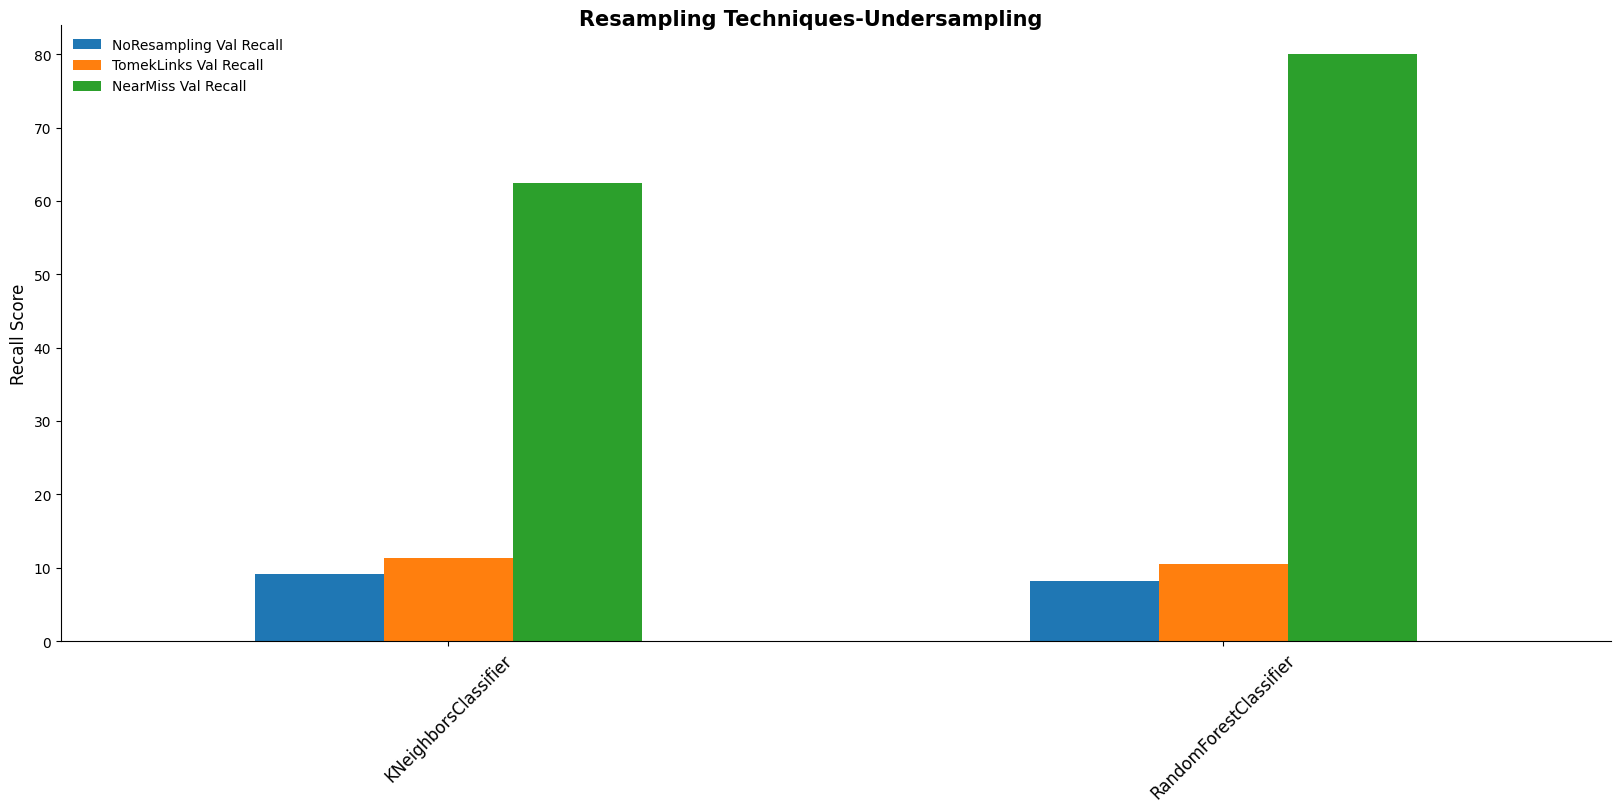

In [13]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [15]:
# Accuracy
ps_under_acc = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_under_acc['TomekLinks Val Accuracy'] = outputs_u[0]['Val Accuracy']
ps_under_acc['NearMiss Val Accuracy'] = outputs_u[1]['Val Accuracy']
ps_under_acc

,TomekLinks Val Accuracy,NearMiss Val Accuracy
KNeighborsClassifier,89.63,52.49
RandomForestClassifier,90.33,36.53


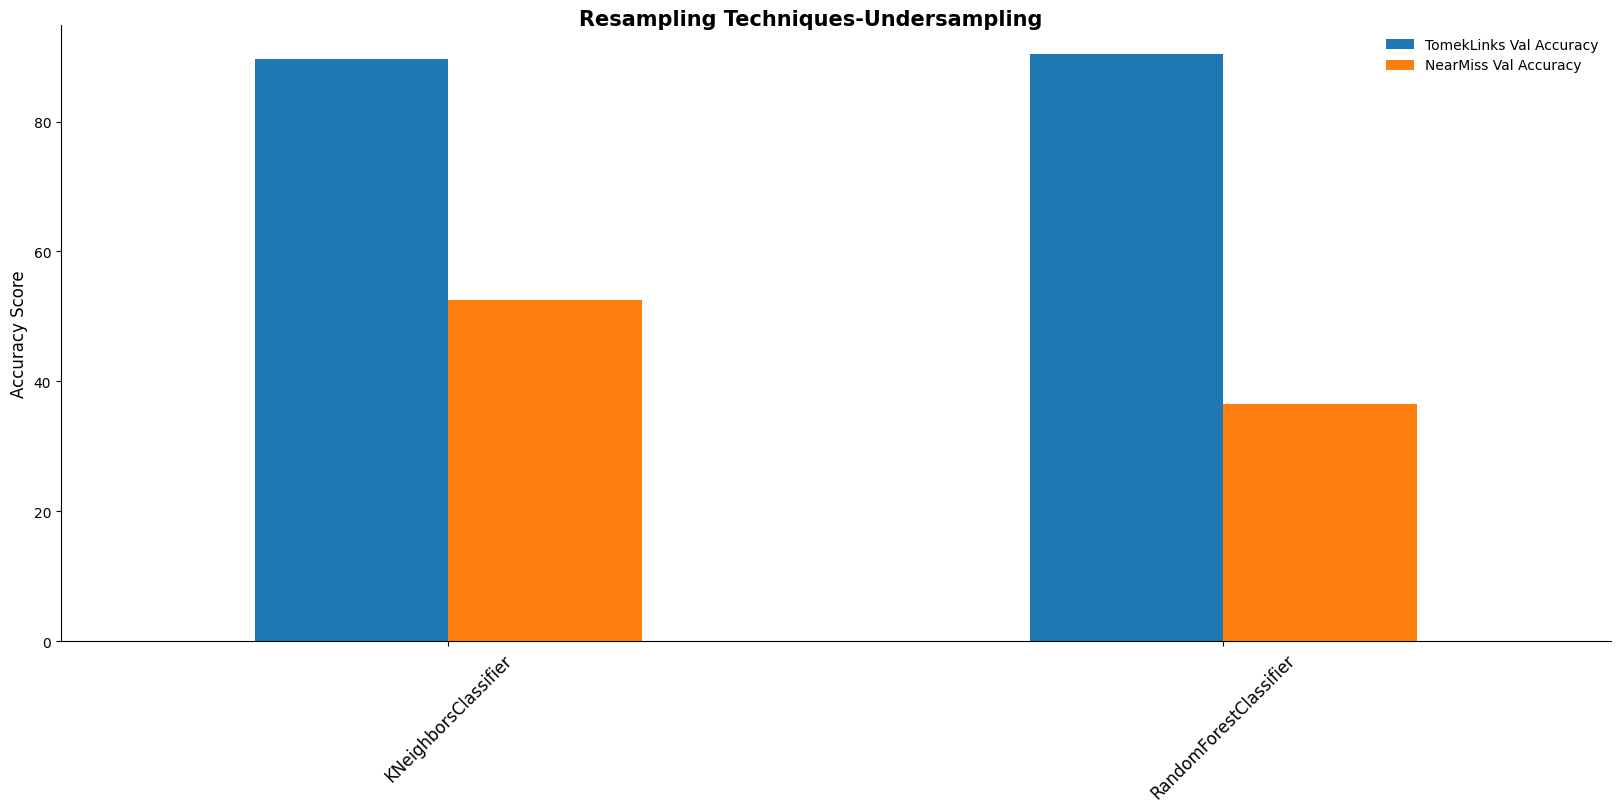

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

### Oversampling

In [17]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, 
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.8879644870758057
Resampling done in 1.2642486095428467
Resampling done in 1.0413322448730469
Resampling done in 0.9797201156616211
Resampling done in 0.9524829387664795


0it [00:00, ?it/s]

Resampling done in 0.8228662014007568
Resampling done in 0.9526910781860352
Resampling done in 1.1153836250305176
Resampling done in 0.8578569889068604
Resampling done in 0.8841187953948975


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Train Precision,Val Precision,Train F1 Score,Val F1 Score,Run Time
KNeighborsClassifier,88.14%,68.92%,99.26%,64.05%,81.20%,17.48%,89.33%,27.46%,133.848037
RandomForestClassifier,99.60%,89.78%,99.51%,16.03%,99.68%,36.96%,99.59%,22.36%,90.933399


--------------------------------------------------ADASYN---------------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 3.726442813873291
Resampling done in 3.256866216659546
Resampling done in 3.264354705810547
Resampling done in 3.199436664581299
Resampling done in 3.284655809402466


0it [00:00, ?it/s]

Resampling done in 3.4809091091156006
Resampling done in 3.397613525390625
Resampling done in 3.4446780681610107
Resampling done in 3.3030831813812256
Resampling done in 3.777336597442627


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Train Precision,Val Precision,Train F1 Score,Val F1 Score,Run Time
KNeighborsClassifier,87.66%,67.83%,99.32%,65.08%,80.50%,17.11%,88.92%,27.10%,132.942781
RandomForestClassifier,99.59%,89.74%,99.50%,15.48%,99.68%,36.31%,99.59%,21.70%,86.814591


In [18]:
# Accuracy
ps_over_acc = pd.DataFrame(index=models_dict.keys())
ps_over_acc['Baseline Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_over_acc['SMOTE Val Accuracy'] = outputs[0]['Val Accuracy']
ps_over_acc['ADASYN Val Accuracy'] = outputs[1]['Val Accuracy']
ps_over_acc

,Baseline Val Accuracy,SMOTE Val Accuracy,ADASYN Val Accuracy
KNeighborsClassifier,89.85,68.92,67.83
RandomForestClassifier,90.38,89.78,89.74


In [ ]:
# ps_over_acc.to_csv('ps_over_acc.csv', index=False)

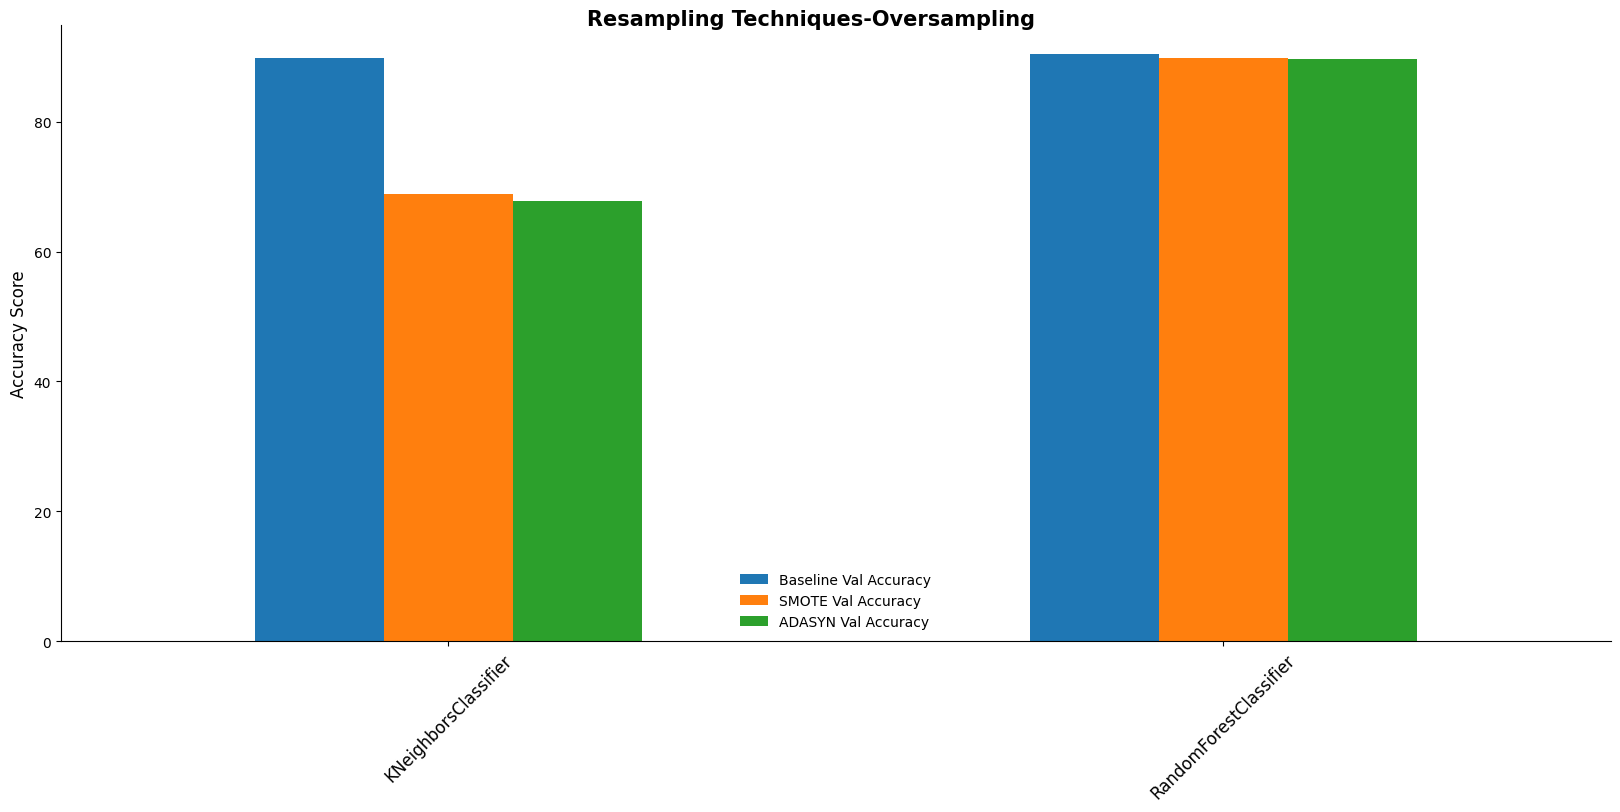

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [20]:
# Recall
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['Baseline Val Recall'] = auto_run[0]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
ps_over

,Baseline Val Recall,SMOTE Val Recall,ADASYN Val Recall
KNeighborsClassifier,9.12,64.05,65.08
RandomForestClassifier,8.17,16.03,15.48


In [ ]:
# ps_over.to_csv('ps_over_rec.csv', index=False)

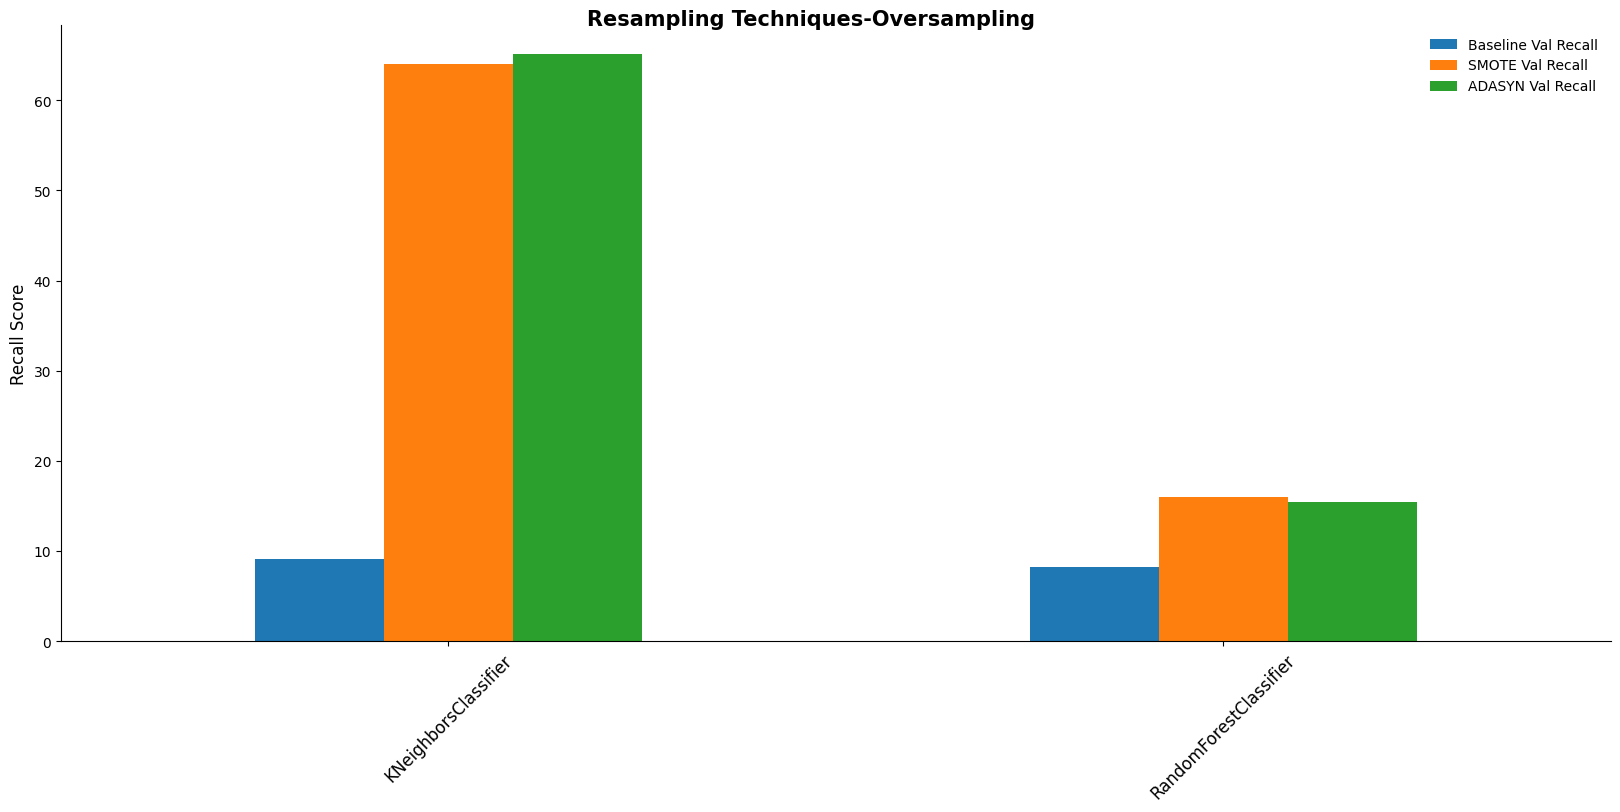

In [21]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [ ]:
outputs

## Hyperparameter Tuning

### NearMiss

In [24]:
def train_knn(X, y, metric, res_t=None, hypertune=False, resample=False):
    params = {"n_neighbors": [3, 5, 7, 9]}
    new_params = {'kneighborsclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(), res_t, KNeighborsClassifier())
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['KNeighbors Classifier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['KNeighbors Classifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [25]:
start_time_knn = time.time()
knn_nm_rec = train_knn(X_trainval, y_trainval, 'recall', NearMiss(),
                       hypertune=True, resample=True)
end_time_knn = time.time()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START kneighborsclassifier__n_neighbors=3.........................
[CV 1/5; 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=0.667, test=0.568) total time=   3.0s
[CV 2/5; 1/4] START kneighborsclassifier__n_neighbors=3.........................
[CV 2/5; 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=0.668, test=0.550) total time=   3.0s
[CV 3/5; 1/4] START kneighborsclassifier__n_neighbors=3.........................
[CV 3/5; 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=0.664, test=0.577) total time=   3.2s
[CV 4/5; 1/4] START kneighborsclassifier__n_neighbors=3.........................
[CV 4/5; 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=0.664, test=0.553) total time=   3.4s
[CV 5/5; 1/4] START kneighborsclassifier__n_neighbors=3.........................
[CV 5/5; 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=0.663, test=0.555) total time=   3.2s


In [26]:
knn_nm_rec

['KNeighbors Classifier',
 0.6072316199114496,
 0.560623935142305,
 "Best parameters = {'kneighborsclassifier__n_neighbors': 3}",
 175.30846881866455,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('nearmiss', NearMiss()),
                 ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])]

In [27]:
start_time_knn1 = time.time()
knn_nm_acc = train_knn(X_trainval, y_trainval, 'accuracy', NearMiss(),
                       hypertune=True, resample=True)
end_time_knn1 = time.time()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START kneighborsclassifier__n_neighbors=3.........................
[CV 1/5; 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=0.644, test=0.628) total time=   3.0s
[CV 2/5; 1/4] START kneighborsclassifier__n_neighbors=3.........................
[CV 2/5; 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=0.646, test=0.633) total time=   3.0s
[CV 3/5; 1/4] START kneighborsclassifier__n_neighbors=3.........................
[CV 3/5; 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=0.643, test=0.635) total time=   3.0s
[CV 4/5; 1/4] START kneighborsclassifier__n_neighbors=3.........................
[CV 4/5; 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=0.647, test=0.631) total time=   2.9s
[CV 5/5; 1/4] START kneighborsclassifier__n_neighbors=3.........................
[CV 5/5; 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=0.645, test=0.630) total time=   3.0s


In [28]:
knn_nm_acc

['KNeighbors Classifier',
 0.6634560284236098,
 0.6745723954469096,
 "Best parameters = {'kneighborsclassifier__n_neighbors': 9}",
 171.30359745025635,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('nearmiss', NearMiss()),
                 ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=9))])]

In [29]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [knn_nm_rec[0],
                np.round(knn_nm_acc[1]*100, 6),
                np.round(knn_nm_acc[2]*100, 6),
                np.round(knn_nm_rec[1]*100, 6),
                np.round(knn_nm_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [knn_nm_rec[0],
                 '{:.2f}%'.format(np.round(knn_nm_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(knn_nm_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(knn_nm_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(knn_nm_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
KNeighbors Classifier,66.35%,67.46%,60.72%,56.06%


In [32]:
# re-fitting for the holdout
rh = knn_nm_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

In [34]:
# cross-validation
base_var = train_knn(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [35]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(knn_nm_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(knn_nm_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,22.59%,10.89%,11.16%
Resampling x Hypertune,60.72%,56.06%,56.00%


## Save the Model

In [50]:
model = rh['kneighborsclassifier']
pickle.dump(model, open('knn_nm.pkl', 'wb'))

## Model Explainability

In [40]:
shap.initjs()

model = rh['kneighborsclassifier']
background_data = shap.kmeans(X_trainval, 1000)
explainer = shap.KernelExplainer(model.predict_proba, background_data)
shap_values = explainer.shap_values(X_holdout.iloc[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_holdout.iloc[0,:])